# Proje: Aygaz Görüntü İşleme Bootcamp
***Projenin amacı:*** Bu projede makine öğrenimi ve görüntü işleme teknikleri ile belirlenen hayvan türlerini sınıflandıran bir model geliştirmek hedefleniyor. Parlaklık arttırma, renk sabitliği gibi yöntemlerle model dayanıklılığı ölçüldü.


# Kullanılan Kütüphaneler ve İşlevleri
* **os:** Dosya ve klasör yönetimi.
* **numpy:** Sayısal işlemler ve veri manipülasyonu.
* **cv2:** Görüntü işleme ve boyutlandırma.
* **train_test_split:** Veriyi eğitim ve test setlerine böler.
* **ImageDataGenerator:** Veri arttırma için kullanılır.
* **Sequential:** Katmanları sıralı eklemek için kullanılır.
* **Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input:** -sırasıyla- Görüntüden özellikleri çıkarır, önemli özellikleri seçer, 2D diziyi 1D matrise dönüştürür, modelin öğrenmesi gereken ağırlık ve bias değerini barındırır, modelin fazla ezber yapmasını engeller, modelin giriş boyutunu tanımlar.
* **Adam:** Optimizasyon algoritmasıdır.
* **matplotlib.pyplot:** Veri görselleştirmek için. 

In [1]:
import os
import numpy as np
import cv2 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam 
import matplotlib.pyplot as plt

# 2. Veri Setinin Hazırlanması
## 2.1 Sınıfların Seçimi ve Dengelenmesi

* *Bu işlemde 10 hayvan türünü veri setinden seçiyoruz ve klasöre taşıyoruz ardından veri miktarını dengeliyoruz.*
  1. *Verilerin çekileceği yolu ve kaydedileceği yolları belirleniyor.*
  2. *Her sınıf için 650 görsel seçildi ve yalnızca bu dosyalar kaydedildi. Bu sayede veri sayısı dengelendi.*
  3. *Önce ana dosya oluşturuldu. Ardından her sınıf için klasör oluşturuldu ve seçili dosyalar ait oldukları klasörlere kopyalandı.*

In [2]:
source_dir = "/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages"
target_dir = "/kaggle/working/FilteredImages"

selected_classes = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]
images_per_class = 650 

os.makedirs(target_dir, exist_ok=True)

for class_name in selected_classes: 
    
    class_path = os.path.join(source_dir, class_name) 
    target_path = os.path.join(target_dir, class_name) 
    os.makedirs(target_path, exist_ok=True) 
    
    for i, file_name in enumerate(os.listdir(class_path)): 
        if i >= images_per_class:
            break
        full_file_name = os.path.join(class_path, file_name)
        if os.path.isfile(full_file_name): 
            cv2.imwrite(os.path.join(target_path, file_name), cv2.imread(full_file_name))
            
print("Veri seti hazırlandı ve dengelendi.")


Veri seti hazırlandı ve dengelendi.


## 2.2 Görüntülerin Boyutlandırılması ve Normalizasyonu
* Bu işlemde görüntülerin daha kolay işlenebilmesi için normalizasyon ve tekrar boyutlandırma işlemi yapıyoruz.
  1. Bu işlem için **load_and_process_images** fonksiyonunu kullandık. Fonksiyonun parametreleri ise veri setini kopyaladığımız klasör ve görsellerin boyutlandırılacağı boyut. 
      * Önce resimlerin ve sınıfların isimlerinin tutulacağı birer liste oluşturduk.
      * Ardından bir döngü ile tüm dosyaların içine girip tek tek içindeki dosyaları okuyoruz ***(cv2.imread())***.
      * Eğer dosya boş değilse (yani görsel varsa) görsele 128x128 boyutlandırması yapıyoruz. ***(cv2.resize(img, image_size))***
      * Öğrenme verimini arttırması için ***(img_resized / 255.0)*** işlemini yapıyoruz. Bu işlem görseli [0-1] aralığında normalleştirir.
      * Ardından normalizasyon işlemi tamamlanan görsel klasöre eklenir ve ait olduğu sınıf adıyla etiketlendirilir. Bu etiket sayesinde makinenin öğrenimi kolaylaşır.
  2. Görüntüyü (x) ve sınıf etiketini (y) olmak üzere fonksiyonu kullanarak değişkenlere atar.

In [3]:
def load_and_process_images(data_dir, image_size=(128, 128)):
    
    images = []
    labels = []
    
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        
        if os.path.isdir(class_path):
            
            for file_name in os.listdir(class_path): 
                file_path = os.path.join(class_path, file_name)
                img = cv2.imread(file_path) 
                
                if img is not None: 
                    img_resized = cv2.resize(img, image_size)
                    img_normalized = img_resized / 255.0 
                    images.append(img_normalized)
                    labels.append(class_name)
                    
    return np.array(images), np.array(labels)

data_dir = target_dir
X, y = load_and_process_images(data_dir)

print(f"Veri kümesi boyutu: {X.shape}") 

Veri kümesi boyutu: (6500, 128, 128, 3)


## 2.3 Verilerin Eğitim ve Test Seti Olarak Ayrılması
* Verilerin %80'ni eğitim için kalan %20'luk kısmını test için kullanacağız. Bu ayrım için öncelikle birtakım işlemler yapılması gerek.
1. Gerekli kütüphaneleri kodumuza import ederek başlıyoruz. Bunların ilki *LabelEncoder*. Bu fonksiyon ile classların isimlerini sayısal değerlere çevireceğiz. İkincisi ise *to_categorical* bu fonksiyon ile sayısal etiketleri her sınıf için tek bir vektör içeren "one-hot" formatına dönüştüreceğiz.
2. ***encoder = LabelEncoder()*** satırıyla örneğin collie=0 gibi bir atama yapar.
3. ***y_encoded = encoder.fit_transform(y)*** y içerisindeki sınıf etiketlerini öğrenir ve bu etiketleri sayısal değerlere dönüştürür.
4. ***y_categorical = to_categorical(y_encoded)***  buradan gelen veri örneğin 0 etiketi için [1,0,0,...] gibi bir değer. Bu işlem sınıflandırma işleminin verimini arttırır.
5. Sonrasında ***train_test_split*** fonksiyonu ile verinin yüzde kaçının test için kullanılacağını belirleriz. *random_state=42* ifadesi ile verilerin her seferinde aynı şekilde bölünmesini sağlarız.

In [4]:
from sklearn.preprocessing import LabelEncoder 
from tensorflow.keras.utils import to_categorical 

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
print(f"Eğitim veri boyutu: {X_train.shape}, Test veri boyutu: {X_test.shape}")

Eğitim veri boyutu: (5200, 128, 128, 3), Test veri boyutu: (1300, 128, 128, 3)


# 3. Veri Artırımı (Augmentation)
* Bu işlem eğitim miktarını arttırmak için önemlidir. Bu aşama sayesinde daha fazla verimiz olur.
* **ImageDataGenerator** fonksiyonunun içine veri arttırma methodlarını ve parametrelerini giriyoruz. Bu işlemler sırasıyla:
1. Görüntüleri belirlenen aralık dahilinde rastgele döndürür ***(rotation_range)***
2. Girilen parametre kadar görseli yatay ve dikey olarak kaydırır. ***(width_shift_range ve height_shift_range)***
3. Girilen parametre kadar görseli eğik olarak kaydırır. ***(shear_range)***
4. Görseli girilen parametre kadar rastgele olarak yakınlaştırır veya uzaklaştırır ***(zoom_range)***
5. Görselin verilen aralıkta rastgele parlaklığını arttırır veya azaltır. ***(brightness_range)***
6. Renk kanallarını belirlenen kadar kaydırır. ***(channel_shift_range)***
7. Aynalama işlemi yapar. ***(horizontal_flip)***
8. Kaydırma vb. işlemlerde boşlukları en yakın piksellerin ortalama değeriyle doldurur. ***(fill_mode='nearest')***
* Bu fonksiyonun ardından *datagen.fit(X_train)* satırıyla hangi verilerde bu işlemleri uygulayacağımızı belirleriz. 

In [5]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    channel_shift_range=50.0,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# 4. CNN Modelinin Oluşturulması
* Bu işlemde CNN modelini ve katmanlarını oluşturuyoruz.
* **Sequential** ile katmanların sırasıyla eklenmesini sağlarız. Sırasıyla:
    1. *Input(shape=(128, 128, 3))* giriş katmanıdır, veri boyutunu tanımlar.
    2. *Conv2D(32, (3, 3), activation='relu')*, görüntüden özellikleri çıkarır, 32 tane filtre kullanır, (3,3) boyutundaki filtreleri uygular. 'relu' ifadesi negatif değerleri sıfıra eşitler bu sayede doğrusal olmayanlık katar ve öğrenmeyi hızlandırır.
    3. *MaxPooling2D(pool_size=(3,3))*, harita boyutunu küçülterek işlem yükünü azaltır, sadece önemli bilgileri korur.
    4. *Flatten()*, özellik haritalarını tek boyutlu vektörlere dönüştürür.
    5. *Dense(128, activation='relu')*, daha yüksek seviyeli ilişkileri öğrenir 128 nöron bulundurur.
    6. *Dense(10, activation='softmax')*, 10 sınıf arasında olasılık dağılımını üretir.

In [6]:
from tensorflow.keras.layers import Input

model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(), 
    Dense(128, activation='relu'),    
    Dense(10, activation='softmax')
])

# 5. Modelin Eğitilmesi
* Modeli oluşturduktan sonra sıra modeli eğitmekte.
* Optimizasyon algoritması olarak **adam** kullandık.
* Kayıp fonksiyonu olarak **categorical_crossentropy** kullanıldı.
* Bu yapı görsel sınıflandırma için uygundur. Doğruluk metriği ile başarı oranı değerlendirilir.
* Tekrar veri arttırma yaparak modelin daha fazla eğitilmesini ve genellenebilirliğini arttırdık.
* Eğitim ve test jeneratörleri yani **train_generator ve validation_generator** ile eğitim ve test verileri işlenir. Bu jeneratörler her seferinde belli miktarda (batch_size) veri ile modeli eğitir.
* *steps_per_epoch* ile eğitim verisetiyle bir epochta(epoch: verilerin tamamının bir kez okunması) kaç adım uygulanacak hesaplanır. Bu (eğitim veriseti büyüklüğü/batch_size) ile hesaplanır.
* *validation_steps* ile test verisetinde doğrulama yapılırken kaç adım olacağı hesaplanır. Bu (test veriseti büyüklüğü/batch_size) ile hesaplanır.
* *train_generator* eğitim verilerini yükler ve işler.
* *validation_generator* doğrulama verilerini yükler.
* Burada 45 epoch ile eğitim yapacağız. 

In [7]:
model.compile(
    optimizer='adam',       
    loss='categorical_crossentropy', 
    metrics=['accuracy']  
)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_generator = datagen.flow(X_train, y_train, batch_size=32) 
validation_generator = datagen.flow(X_test, y_test, batch_size=32) 

steps_per_epoch = len(X_train) // 32
validation_steps = len(X_test) // 32

history = model.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=45,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/45


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


162/162 ━━━━━━━━━━━━━━━━━━━━ 73s 435ms/step - accuracy: 0.2869 - loss: 2.0060 - val_accuracy: 0.4414 - val_loss: 1.5722
Epoch 2/45
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.5000 - loss: 1.5404 - val_accuracy: 0.5000 - val_loss: 1.5698
Epoch 3/45


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


162/162 ━━━━━━━━━━━━━━━━━━━━ 61s 368ms/step - accuracy: 0.4962 - loss: 1.4623 - val_accuracy: 0.5602 - val_loss: 1.2729
Epoch 4/45
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.5625 - loss: 1.1848 - val_accuracy: 0.4000 - val_loss: 1.5093
Epoch 5/45
162/162 ━━━━━━━━━━━━━━━━━━━━ 60s 367ms/step - accuracy: 0.5806 - loss: 1.2538 - val_accuracy: 0.6031 - val_loss: 1.1615
Epoch 6/45
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.6875 - loss: 1.0208 - val_accuracy: 0.6000 - val_loss: 1.0133
Epoch 7/45
162/162 ━━━━━━━━━━━━━━━━━━━━ 60s 364ms/step - accuracy: 0.6013 - loss: 1.1709 - val_accuracy: 0.5961 - val_loss: 1.1566
Epoch 8/45
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - accuracy: 0.5000 - loss: 1.3991 - val_accuracy: 0.4000 - val_loss: 1.3936
Epoch 9/45
162/162 ━━━━━━━━━━━━━━━━━━━━ 60s 367ms/step - accuracy: 0.6454 - loss: 1.0310 - val_accuracy: 0.6234 - val_loss: 1.0885
Epoch 10/45
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.5000 - loss: 1.3461 - val_ac

# 6. Modelin Test Edilmesi
* Burada performans değerlendirilir ve 2 ondalıklı olacak şeklilde yüzdelik dilimi çıktısı alınır.

In [8]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Doğruluğu: {test_accuracy * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.7371 - loss: 0.7835 
Test Doğruluğu: 73.15%


# 7.Model Eğitimi Sonuçlarının Görselleştirilmesi
* Bu kod, bir derin öğrenme modelinin eğitim süreci boyunca doğruluk ve kayıp metriklerini görselleştiren iki alt grafik oluştururuz.
* Birinci alt grafikte doğruluk metriklerini görürüz. İkinci grafikte ise kayıp metriklerini görürüz.
* Doğruluk Grafiği ile modelin eğitim sürecinde ne kadar doğru tahmin yaptığı gözlemlenir. Eğitim doğruluğunun doğrulama doğruluğundan çok yüksek olması, aşırı öğrenme (overfitting) işaretidir. 
* Kayıp Grafiği ile modelin hatalarının (kayıp) eğitim ve doğrulama setlerindeki değişimi gösterir. Eğitim kaybının doğrulama kaybından çok düşük olması, modelin sadece eğitim verilerine uyum sağladığını gösterebilir.
Bu grafikler sayesinde modelin performansını değerlendirerek iyileştirme yapabiliriz. 

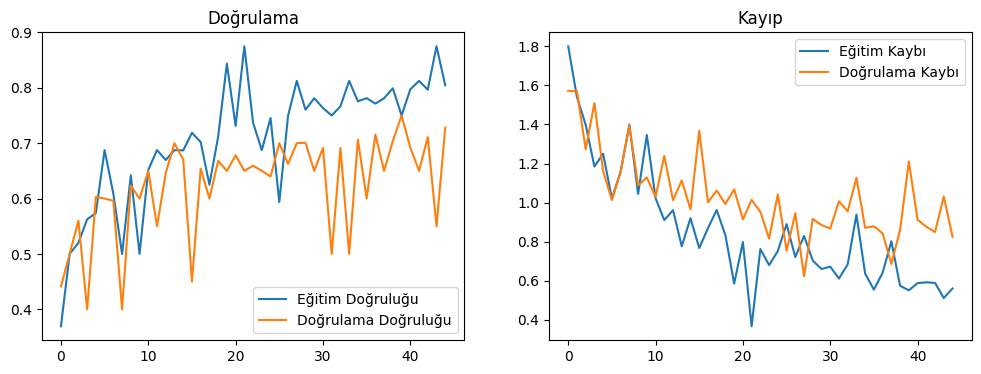

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.legend()
plt.title('Doğrulama')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.legend()
plt.title('Kayıp')

plt.show()

# 8. Manipüle Edilmiş Test
* Bu adımda modelin görüntü manipülasyonuna dayanıklılığını ölçeceğiz.
* **cv2.convertScaleAbs(img, alpha=2.0, beta=0)** işlemi ile görüntünün kontrastını arttırdık. Alpha, kontrast iken beta, parlıklığı ifade eder.
* **cv2.rotate(manipulated, cv2.ROTATE_90_CLOCKWISE)** işlemiyle görüntüyü saat yönünde 90 derece döndürdük. Manipüle edilen her dizi bir dizi içine alınır ve ardından model bu verilerle test edilir. Buradan aldığımız verilerin işlenmesiyle modelin dayanıklılığını ölçeriz. Düşük doğruluk, modelin veri çeşitliliğine hassas olduğunu gösterir. 

In [10]:
def get_manipulated_images(images):
    manipulated_images = [] 
    for img in images:
        manipulated = cv2.convertScaleAbs(img, alpha=2.0, beta=0)
        manipulated = cv2.rotate(manipulated, cv2.ROTATE_90_CLOCKWISE)
        manipulated_images.append(manipulated)
    return np.array(manipulated_images)

X_test_manipulated = get_manipulated_images(X_test)
manipulated_loss, manipulated_accuracy = model.evaluate(X_test_manipulated, y_test)
print(f"Manipüle Edilmiş Test Doğruluğu: {manipulated_accuracy * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.3538 - loss: 5.5767
Manipüle Edilmiş Test Doğruluğu: 33.62%


# 9.Manipüle Edilmiş Görüntünün Doğruluk Grafiği
* Bu işlemde modelin eğitim ve doğrulama sürecindeki performansını görselleştirirken, manipüle edilmiş test verileri üzerinden elde edilen doğruluk ve kayıp değerlerini de aynı grafikte gösterdik. Bu sayede modelin dayanıklılığını daha kolay bir şekilde ölçebiliriz. 

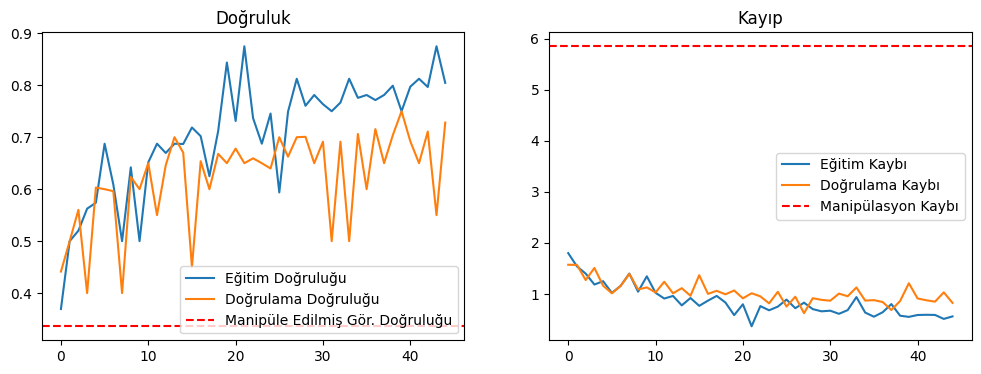

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.axhline(manipulated_accuracy, color='r', linestyle='--', label='Manipüle Edilmiş Gör. Doğruluğu')
plt.legend()
plt.title('Doğruluk')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.axhline(manipulated_loss, color='r', linestyle='--', label='Manipülasyon Kaybı')
plt.legend()
plt.title('Kayıp')
plt.show()

# 9. Renk Sabitliği (Gray World Algoritması)
* Bu işlemde "Gray World Assumption" kullanılarak bir görüntüde renk sabitliği uygular. Renk sabitliği, farklı aydınlatma koşullarında modelin daha tutarlı sonuçlar vermesini sağlamaya yönelik bir tekniktir. Bu sayede modelin performansını ve dayanıklılığını ölçebiliriz. 
* İlk önce ***apply_color_constancy*** fonksiyonuyla başlayacağız. Parametresi yalnızca kullanacağımız dosya. Dosyanın(görüntünün) boş olup olmadığını kontrol ederiz. Eğer boşsa geriye None döner yani o görüntü atlanır.
* Eğer dosya boş değilse her kanalın piksel ortalamasını hesaplarız **(avg_b, avg_g, avg_r)**. Bu piksel ortalamalarının aritmetik ortalamasını alarak genel bir gri seviye elde edilir **(avg_gray)**.
*  Ardından her kanalı sırasıyla gri değerine göre dengeleriz. **np.clip(...,0,255)** ifadesiyle piksellerin 0 ve 255 arasında kalmasını sağlarız. Aksi takdirde çok parlak olan pikseller 255 değerini geçebilir. Normalize edilmiş görüntüyü geri döndürürüz. 
*  Ardından ***load_and_process_images_with_color_constancy*** fonksiyonuyla dizindeki görüntüleri yükler ve renk sabitliği uygulayarak modele uygun hale getiririz ve işleriz. En son doğruluk ve kayıp oranını hesaplarız.

In [12]:
def apply_color_constancy(imgs):
    color_const_images = [] 

    for img in imgs: 
        if img is None:
            continue 

        avg_b = np.mean(img[:, :, 0])
        avg_g = np.mean(img[:, :, 1])
        avg_r = np.mean(img[:, :, 2])

        avg_gray = (avg_b + avg_g + avg_r) / 3

        img[:, :, 0] = np.clip((img[:, :, 0] * (avg_gray / avg_b)), 0, 255)
        img[:, :, 1] = np.clip((img[:, :, 1] * (avg_gray / avg_g)), 0, 255)
        img[:, :, 2] = np.clip((img[:, :, 2] * (avg_gray / avg_r)), 0, 255)

        color_const_images.append(img)

    return np.array(color_const_images) 
    
X_test_colorconst = apply_color_constancy(X_test)

colorconst_loss, colorconst_accuracy = model.evaluate(X_test_colorconst, y_test)
print(f"Renk Sabitliği Uygulanmış Test Doğruluğu: {colorconst_accuracy * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.6152 - loss: 1.4616
Renk Sabitliği Uygulanmış Test Doğruluğu: 63.46%


# 10. Sonuçların Karşılaştırılması
* Sonuçların sayısal karşılaştırılması yapılır. 

In [13]:
print("Sonuçlar:")
print(f"Orijinal Test Seti Doğruluğu: {test_accuracy * 100:.2f}%")
print(f"Manipüle Edilmiş Test Seti Doğruluğu: {manipulated_accuracy * 100:.2f}%")
print(f"Renk Sabitliği Uygulanmış Test Seti Doğruluğu: {colorconst_accuracy * 100:.2f}%")

Sonuçlar:
Orijinal Test Seti Doğruluğu: 73.15%
Manipüle Edilmiş Test Seti Doğruluğu: 33.62%
Renk Sabitliği Uygulanmış Test Seti Doğruluğu: 63.46%


# 11.Sonuçların Grafik ile Karşılaştırılması
* Bu işlemde orjinal, manipüle edilmiş ve renk sabitliği uygulanmış görüntülerin verilerinin grafikleri karşılaştırma yapılabilmesi adına görselleştirilmiştir.
* Eğer manipüle edilmiş veya renk sabitliği uygulanmış doğruluk, orijinal doğrulukla benzer ise model genel anlamda dayanıklıdır.
Manipülasyon veya renk sabitliği sonucunda büyük doğruluk kaybı varsa model veri çeşitliliğine duyarlıdır ve veri artırma (data augmentation) gibi teknikler gerekebilir.

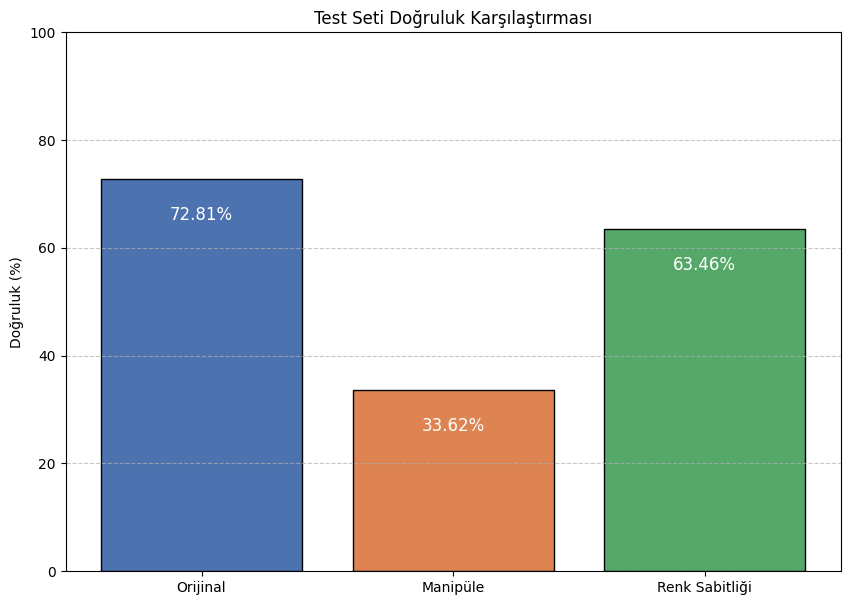

In [14]:
original_accuracy = history.history['val_accuracy'][-1]  

accuracies = [
    original_accuracy * 100,  
    manipulated_accuracy * 100, 
    colorconst_accuracy * 100  
]

labels = ['Orijinal', 'Manipüle', 'Renk Sabitliği']

plt.figure(figsize=(10, 7))
colors = ['#4c72b0', '#dd8452', '#55a868'] 
bars = plt.bar(labels, accuracies, color=colors, edgecolor='black')

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, f'{acc:.2f}%', ha='center', va='top', fontsize=12, color='white')

plt.ylim(0, 100) 
plt.ylabel('Doğruluk (%)')
plt.title('Test Seti Doğruluk Karşılaştırması')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

* Modelim ile aldığım sonuçlarda arada farklılıklar bulunmakta. Bu farklar veri arttırma yöntemlerini geliştirerek, modeli iyileştirerek dengelenebilir. Örneğin:abs
  1. Artırma Parametrelerini Dengeleme: Özellikle parlaklık, renk ve dönüşüm gibi manipülasyonları sınırlayarak modelin doğru öğrenmesini sağlayabiliriz. Örneğin, parlaklık değişimi veya kanal kayması gibi manipülasyonlar fazla yapıldığında model, gerçek dünyadaki varyasyonları öğrenmekte zorlanabilir.
  2. Modelin doğruluğunda belirgin bir düşüş gözlemliyoruz, bu da modelin aşırı uyum sağlamış (overfitting) olabileceğini gösterir. Modelin daha genelleştirilebilir olabilmesi için şunları yapılabiliriz:
     * Daha derin ve karmaşık modeller kullanılabilir. Basit bir CNN modelinin sınırlamaları olabilir. Daha derin veya daha karmaşık modeller kullanarak daha iyi sonuçlar alabiliriz.
     * Dropout ve Batch Normalization kullanılabilir. Aşırı uyum (overfitting) riskini azaltmak için dropout katmanları veya batch normalization eklemeyi düşünebiliriz.